In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fraudfinder - Training formalization

<table align="left">
  <td>
    <a href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?&download_url=https://github.com/GoogleCloudPlatform/fraudfinder/raw/main/05_model_training_formalization.ipynb">
       <img src="https://www.gstatic.com/cloud/images/navigation/vertex-ai.svg" alt="Google Cloud Notebooks">Open in Cloud Notebook
    </a>
  </td> 
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/fraudfinder/blob/main/05_model_training_formalization.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Open in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/fraudfinder/blob/main/05_model_training_formalization.ipynb">
        <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

## Overview

[Fraudfinder](https://github.com/googlecloudplatform/fraudfinder) is a series of labs on how to build a real-time fraud detection system on Google Cloud. Throughout the Fraudfinder labs, you will learn how to read historical bank transaction data stored in data warehouse, read from a live stream of new transactions, perform exploratory data analysis (EDA), do feature engineering, ingest features into a feature store, train a model using feature store, register your model in a model registry, evaluate your model, deploy your model to an endpoint, do real-time inference on your model with feature store, and monitor your model.

### Objective

This notebook shows how to get your training dataset from Vertex AI Feature Store, train your model using Vertex AI managed training pipeline, and deploy it as a Vertex AI endpoint. You will learn how to use your own custom code for ML training on Vertex AI.

This lab uses the following Google Cloud services and resources:

- [Vertex AI](https://cloud.google.com/vertex-ai/)
- [BigQuery](https://cloud.google.com/bigquery/)

Steps performed in this notebook:

* build a container to run your own custom code on Vertex AI
* use Vertex AI to train your model at scale
* use Vertex AI to create an endpoint

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage
* BigQuery

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [BigQuery pricing](https://cloud.google.com/bigquery/pricing) and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Load configuration settings from the setup notebook

Set the constants used in this notebook and load the config settings from the `00_environment_setup.ipynb` notebook.### Load config settings

In [1]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
BUCKET_NAME = f"{PROJECT_ID}-vision-workshop"
config = !gsutil cat gs://{BUCKET_NAME}/config/notebook_env.py
print(config.n)
exec(config.n)


BUCKET_NAME          = "temp-vision-workshop-vision-workshop"
PROJECT              = "temp-vision-workshop"
REGION               = "europe-west4"
ID                   = "7l3oe"
MODEL_NAME           = "vision_workshop_model"
ENDPOINT_NAME        = "vision_workshop_endpoint"



In [2]:
from datetime import datetime, timedelta

END_DATE_TRAIN = datetime.today().strftime("%Y-%m-%d")

## Custom Training
DATASET_NAME=f"sample_train-{ID}-{END_DATE_TRAIN}"
TRAIN_JOB_NAME=f"vision_train_frmlz-{ID}"
MODEL_NAME=f"vision_model_frmlz-{ID}"
DEPLOYED_NAME = f"vision_prediction_frmlz-{ID}"
MODEL_SERVING_IMAGE_URI = "europe-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest"
IMAGE_REPOSITORY = f"vision-{ID}"
IMAGE_NAME="image-classifier"
IMAGE_TAG="v1"
IMAGE_URI=f"europe-west4-docker.pkg.dev/{PROJECT_ID}/{IMAGE_REPOSITORY}/{IMAGE_NAME}:{IMAGE_TAG}"
TRAIN_COMPUTE="e2-standard-4"
DEPLOY_COMPUTE="n1-standard-4"

In [3]:
IMAGE_REPOSITORY

'vision-7l3oe'

## Builing a custom Image Classification Model

#### Builing a Vertex AI dataset
In this section, we will build a Vertex AI dataset from our images data. Vertex AI datasets can be used to train AutoML models or custom-trained models.  

In [17]:
from google.cloud import storage
import os

client = storage.Client() 

# Implicit environment set up
# with explicit set up:
# client = storage.Client.from_service_account_json('key-file-location')

blobs = list(client.list_blobs(BUCKET_NAME, prefix='flowers/'))

In [18]:
labels = [os.path.split(os.path.dirname(blob.name))[1] for blob in blobs]

In [19]:
d = [[f"gs://{blob.bucket.name}/{blob.name}", os.path.split(os.path.dirname(blob.name))[1]] for blob in blobs]

In [27]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)

In [28]:
df = pd.DataFrame(d)
df

,0,1
0,gs://temp-vision-workshop-vision-workshop/flowers/daisy/1031799732_e7f4008c03.jpg,daisy
1,gs://temp-vision-workshop-vision-workshop/flowers/daisy/10466558316_a7198b87e2.jpg,daisy
2,gs://temp-vision-workshop-vision-workshop/flowers/daisy/10555749515_13a12a026e.jpg,daisy
3,gs://temp-vision-workshop-vision-workshop/flowers/daisy/11023277956_8980d53169_m.jpg,daisy
4,gs://temp-vision-workshop-vision-workshop/flowers/daisy/12193032636_b50ae7db35_n.jpg,daisy
...,...,...
195,gs://temp-vision-workshop-vision-workshop/flowers/tulips/7166567320_0a2beb6d42.jpg,tulips
196,gs://temp-vision-workshop-vision-workshop/flowers/tulips/7166626128_8e0983ac8e_n.jpg,tulips
197,gs://temp-vision-workshop-vision-workshop/flowers/tulips/8614237582_74417799f4_m.jpg,tulips
198,gs://temp-vision-workshop-vision-workshop/flowers/tulips/8668974855_8389ecbdca_m.jpg,tulips


In [ ]:
df.to_csv(f"gs://{BUCKET_NAME}/flowers/flowers.csv",index=False, header=False)

In [ ]:
ds = vertex_ai.ImageDataset.create(
    display_name="flowers",
    gcs_source=f"gs://{BUCKET_NAME}/flowers/flowers.csv",
    import_schema_uri=vertex_ai.schema.dataset.ioformat.image.single_label_classification,
    sync=True,
)

ds.wait()

print(ds.display_name)
print(ds.resource_name)

In [ ]:
ds = ImageDataset.list(filter="display_name=flowers")[0]

### Train a custom model
In this section, we will use the xgboost algorithm. Specifically, we will perform custom training with a pre-built xgboost container.

#### Create the training application
Typically, to perform custom training you can use either a pre-built container or buid your own container. In this section we will build a container for xgboost, and use it to train a model with the Vertex AI Managed Training service.

The first step is to write your training code. Then, write a Dockerfile and build a container image based on it. The following cell, writes our code into `train_gb.py` which is the module for training a XGBClassifier. We will copy this code later into our container to be run through Vertex Training service.

In [29]:
!mkdir -p -m 777 build_training

In [ ]:
# %%writefile build_training/train_tf.py

# """
# train_tf.py is the module for training a Tensorflow pipeline
# """

# # Libraries --------------------------------------------------------------------------------------------------------------------------
# import argparse
# import json
# import logging
# from pathlib import Path
# import numpy as np
# import os
# import tensorflow as tf
# import tensorflow_datasets as tfds
# import tensorflow_hub as hub
# import time
# from datetime import datetime, timedelta
# from google.cloud import aiplatform as vertex_ai
# from pathlib import Path

# # Variables --------------------------------------------------------------------------------------------------------------------------
# ## Read environmental variables
# TRAINING_DATA_PATH = os.environ["AIP_TRAINING_DATA_URI"].replace("gs://", "/gcs/")
# TEST_DATA_PATH = os.environ["AIP_TEST_DATA_URI"].replace("gs://", "/gcs/")
# MODEL_DIR = os.environ["AIP_MODEL_DIR"].replace("gs://", "/gcs/")

# # Helpers -----------------------------------------------------------------------------------------------------------------------------
# def get_args():
#     parser = argparse.ArgumentParser()

#     # Data files arguments
#     parser.add_argument("--data_dir", dest="data_dir", type=str,
#                         required=True, help="Bucket uri")
#     parser.add_argument("--lr", dest="lr",
#                         default=6, type=float,
#                         help="max_depth value.")
#     parser.add_argument("-v", "--verbose", 
#                         help="increase output verbosity", 
#                         action="store_true")
    
#     return parser.parse_args()

# def set_logging():
#     #TODO
#     pass


# def main():
#     args = get_args()
#     if args.verbose:
#         set_logging()
        
#     #variables
#     data_dir = args.data_dir.replace("gs://", "/gcs/")
#     data_dir = Path(data_dir)

#     #read data
#     print(f"TRAINING_DATA_PATH: {TRAINING_DATA_PATH}")
#     batch_size = 16
#     img_height = 384
#     img_width = 384
    
#     train_ds = tf.keras.utils.image_dataset_from_directory(
#       data_dir,
#       seed=123,
#       image_size=(img_height, img_width),
#       batch_size=batch_size)
#     train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
#     #train model
#     base_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2", trainable=False)
#     # Create new model on top
#     inputs = tf.keras.Input(shape=(img_height, img_width, 3))
#     data_augmentation = tf.keras.Sequential(
#         [
#             tf.keras.layers.RandomFlip("horizontal"), 
#             tf.keras.layers.RandomRotation(0.1),
#             tf.keras.layers.RandomTranslation(0, 0.2),
#             tf.keras.layers.RandomTranslation(0.2, 0),
#             tf.keras.layers.RandomZoom(0.2, 0.2),
#         ]
#     )
#     x = data_augmentation(inputs)  # Apply random data augmentation
#     x = tf.keras.layers.Rescaling(1./255)(x)
#     # The base model contains batchnorm layers. We want to keep them in inference mode
#     # when we unfreeze the base model for fine-tuning, so we make sure that the
#     # base_model is running in inference mode here.
#     x = base_model(x)
#     #x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
#     outputs = tf.keras.layers.Dense(5)(x)
#     model = tf.keras.Model(inputs, outputs)
    
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=['accuracy']
#     )
    
#     reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                               patience=5, min_lr=0.0001)
#     history = model.fit(
#       train_ds,
#       epochs=20, 
#       callbacks=[reduce_lr]
#     )
    
#     if not Path(MODEL_DIR).exists():
#         Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
    
#     CONCRETE_INPUT = "numpy_inputs"

#     def _preprocess(bytes_input):
#         decoded = tf.io.decode_jpeg(bytes_input, channels=3)
#         resized = tf.image.resize(decoded, size=(384, 384))
#         return resized


#     @tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
#     def preprocess_fn(bytes_inputs):
#         decoded_images = tf.map_fn(
#             _preprocess, bytes_inputs, dtype=tf.float32, back_prop=False
#         )
#         return {
#             CONCRETE_INPUT: decoded_images
#         }  # User needs to make sure the key matches model's input


#     @tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
#     def serving_fn(bytes_inputs):
#         images = preprocess_fn(bytes_inputs)
#         prob = m_call(**images)
#         return prob


#     m_call = tf.function(model.call).get_concrete_function(
#         [tf.TensorSpec(shape=[None, 384, 384, 3], dtype=tf.float32, name=CONCRETE_INPUT)]
#     )

#     tf.saved_model.save(
#         model, MODEL_DIR, signatures={
#             "serving_default": serving_fn,
#             # Required for XAI
#             "xai_preprocess": preprocess_fn,
#             "xai_model": m_call
#         }
#     )
    
# if __name__ == "__main__":
#     main()

In [88]:
%%writefile build_training/train_tf.py

"""
train_tf.py is the module for training a Tensorflow Image classifier pipeline
"""

# Libraries --------------------------------------------------------------------------------------------------------------------------
import argparse
import json
import logging
from pathlib import Path
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import time
from datetime import datetime, timedelta
from google.cloud import aiplatform as vertex_ai
from pathlib import Path

# Variables --------------------------------------------------------------------------------------------------------------------------
## Read environmental variables
TRAINING_DATA_PATH = os.environ["AIP_TRAINING_DATA_URI"].replace("gs://", "/gcs/")
TEST_DATA_PATH = os.environ["AIP_TEST_DATA_URI"].replace("gs://", "/gcs/")
MODEL_DIR = os.environ["AIP_MODEL_DIR"].replace("gs://", "/gcs/")

# Helpers -----------------------------------------------------------------------------------------------------------------------------
def get_args():
    parser = argparse.ArgumentParser()

    # Data files arguments
    parser.add_argument("--train-data-dir", default=os.getenv('AIP_TRAINING_DATA_URI'), dest="train_data_dir", type=str, help="train data directory")
    parser.add_argument("--val-data-dir", default=os.getenv('AIP_VALIDATION_DATA_URI'), dest="val_data_dir", type=str, help="validation data directory")
    
    # data preprocessing
    parser.add_argument("--image-width", dest="image_width", default=384, type=int, help="image width")
    parser.add_argument("--image-height", dest="image_height", default=384, type=int, help="image height")
    
    parser.add_argument("--lr", dest="lr",
                        default=0.01, type=float,
                        help="max_depth value.")
    parser.add_argument(
        "--batch-size", dest="batch_size", default=32, type=int, help="mini-batch size"
    )
    parser.add_argument(
        "--epochs", default=10, type=int, help="number of training epochs"
    )
    parser.add_argument(
        "--steps", dest="steps", default=92, type=int, help="Number of steps per epoch.",
    )
    
    return parser.parse_args()


args = get_args()

def get_data():
    class_names = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
    class_indices = dict(zip(class_names, range(len(class_names))))
    num_classes = len(class_names)

    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [args.image_width, args.image_height])
        return image

    def extract(data_dir, batch_size=args.batch_size, repeat=True):
        data = []
        labels = []
        for data_uri in tf.io.gfile.glob(pattern=data_dir):
            with tf.io.gfile.GFile(name=data_uri, mode="r") as gfile:
                for line in gfile.readlines():
                    instance = json.loads(line)
                    data.append(instance["imageGcsUri"])
                    classification_annotation = instance["classificationAnnotations"][0]
                    label = classification_annotation["displayName"]
                    labels.append(class_indices[label])

        data_dataset = tf.data.Dataset.from_tensor_slices(data)
        data_dataset = data_dataset.map(
            parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )

        label_dataset = tf.data.Dataset.from_tensor_slices(labels)

        dataset = tf.data.Dataset.zip((data_dataset, label_dataset)).cache().shuffle(batch_size * 32)
        if repeat:
            dataset = dataset.repeat()
        dataset = dataset.batch(batch_size)

        # Add property to retain the class names
        dataset.class_names = class_names

        return dataset
    
    logging.info('Prepare training data')
    train_dataset = extract(args.train_data_dir)

    logging.info('Prepare validation data')
    val_dataset = extract(args.val_data_dir, batch_size=1, repeat=False)

    return num_classes, train_dataset, val_dataset


def get_model(num_classes):
    logging.info("Get model architecture")
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"), 
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomTranslation(0, 0.2),
            tf.keras.layers.RandomTranslation(0.2, 0),
            tf.keras.layers.RandomZoom(0.2, 0.2),
        ]
    )
    
    # base model
    base_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2", trainable=False)
    # Create new model on top
    inputs = tf.keras.Input(shape=(args.image_height, args.image_width, 3))
    x = data_augmentation(inputs)  # Apply random data augmentation
    x = tf.keras.layers.Rescaling(1./255)(x)
    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(x)
    # x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = tf.keras.layers.Dense(num_classes)(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model


def train_model(model, train_dataset, val_dataset):
    logging.info("Start model training")
    history = model.fit(
        x=train_dataset, epochs=args.epochs, steps_per_epoch=args.steps, batch_size=args.batch_size, validation_data=val_dataset
    )
    return history

        
num_classes, train_dataset, val_dataset = get_data()

model = get_model(num_classes=num_classes)

history = train_model(model, train_dataset, val_dataset)

if not Path(MODEL_DIR).exists():
    Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

CONCRETE_INPUT = "numpy_inputs"


def _preprocess(bytes_input):
    decoded = tf.io.decode_jpeg(bytes_input, channels=3)
    resized = tf.image.resize(decoded, size=(384, 384))
    return resized


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(bytes_inputs):
    decoded_images = tf.map_fn(
        _preprocess, bytes_inputs, dtype=tf.float32, back_prop=False
    )
    return {
        CONCRETE_INPUT: decoded_images
    }  # User needs to make sure the key matches model's input


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def serving_fn(bytes_inputs):
    images = preprocess_fn(bytes_inputs)
    prob = m_call(**images)
    return prob


m_call = tf.function(model.call).get_concrete_function(
    [tf.TensorSpec(shape=[None, 384, 384, 3], dtype=tf.float32, name=CONCRETE_INPUT)]
)

tf.saved_model.save(
    model, MODEL_DIR, signatures={
        "serving_default": serving_fn,
        # Required for XAI
        "xai_preprocess": preprocess_fn,
        "xai_model": m_call
    }
)

Overwriting build_training/train_tf.py


#### Define a custom image for dask model training

Here we will build a custom container. A custom container is a Docker image that you create to run your training application. By running your machine learning (ML) training job in a custom container, you can use ML frameworks, non-ML dependencies, libraries, and binaries that are not otherwise supported on Vertex AI. In othere word, we package training code on our local machine into a Docker container image, push the container image to Container Registry, and create a CustomJob.

For the ML framework we will use xgboost. We also use dask and scikit libraries. Dask is an open source library for parallel computing written in Python. We will use Dask to speed up pre-processing of our dataset.

In [89]:
# Create image repo
!gcloud artifacts repositories create $IMAGE_REPOSITORY \
    --repository-format=docker \
    --location=europe-west4 \
    --description="Vision Workshop Docker Image repository"

# List repositories under the project
!gcloud artifacts repositories list

ERROR: (gcloud.artifacts.repositories.create) ALREADY_EXISTS: the repository already exists
Listing items under project temp-vision-workshop, across all locations.

                                                                                ARTIFACT_REGISTRY
REPOSITORY    FORMAT  MODE                 DESCRIPTION                              LOCATION      LABELS  ENCRYPTION          CREATE_TIME          UPDATE_TIME          SIZE (MB)
vision-7l3oe  DOCKER  STANDARD_REPOSITORY  Vision Workshop Docker Image repository  europe-west4          Google-managed key  2022-11-07T18:05:03  2022-11-17T16:06:49  12206.867


In [90]:
!gcloud auth configure-docker europe-west4-docker.pkg.dev -q


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "europe-west4-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: europe-west4-docker.pkg.dev
gcloud credential helpers already registered correctly.


In [91]:
%%writefile build_training/Dockerfile
# Specifies base image and tag
FROM gcr.io/deeplearning-platform-release/tf-gpu.2-8
WORKDIR /root

# Installs additional packages
RUN pip install gcsfs numpy pandas scikit-learn tensorflow==2.8.3 tensorflow_datasets tensorflow_hub google-cloud-aiplatform --upgrade

# Copies the trainer code to the docker image.
COPY ./train_tf.py /root/train_tf.py

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python3", "train_tf.py"]

Overwriting build_training/Dockerfile


In [92]:
# Build and push docker file
!docker build -t $IMAGE_URI ./build_training/
!docker push $IMAGE_URI

Sending build context to Docker daemon  9.728kB
Step 1/5 : FROM gcr.io/deeplearning-platform-release/tf-gpu.2-8
 ---> c76bc7741e63
Step 2/5 : WORKDIR /root
 ---> Using cache
 ---> f1f22dcbbcc4
Step 3/5 : RUN pip install gcsfs numpy pandas scikit-learn tensorflow==2.8.3 tensorflow_datasets tensorflow_hub google-cloud-aiplatform --upgrade
 ---> Using cache
 ---> d3093c1af1a5
Step 4/5 : COPY ./train_tf.py /root/train_tf.py
 ---> c07a378dca11
Step 5/5 : ENTRYPOINT ["python3", "train_tf.py"]
 ---> Running in 4af6e065b0a6
Removing intermediate container 4af6e065b0a6
 ---> ae05da34999f
Successfully built ae05da34999f
Successfully tagged europe-west4-docker.pkg.dev/temp-vision-workshop/vision-7l3oe/image-classifier:v1
The push refers to repository [europe-west4-docker.pkg.dev/temp-vision-workshop/vision-7l3oe/image-classifier]

51eebca5: Preparing 
26013b4b: Preparing 
187ae0fb: Preparing 
aa5d36ba: Preparing 
de7467e6: Preparing 
dc4c727a: Preparing 
0dfd7b73: Preparing 
6fd7d6bf: Preparing 


#### Submit the script to run on Vertex AI
In this section, we create a training pipeline. It will create custom training jobs, load our dataset and upload the model to Vertex AI after the training job is successfully completed. Learn more about creating of custom jobs [here](https://cloud.google.com/vertex-ai/docs/training/create-custom-job).

In [4]:
from google.cloud import aiplatform as vertex_ai


vertex_ai.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME, experiment="train")


ds = vertex_ai.ImageDataset.list(filter="display_name=flowers_prod")[0]
ds

resource name: projects/446303513828/locations/europe-west4/datasets/4379471361664352256

In [94]:
job = vertex_ai.CustomContainerTrainingJob(
    display_name=TRAIN_JOB_NAME,
    container_uri=IMAGE_URI,
    model_serving_container_image_uri=MODEL_SERVING_IMAGE_URI,
)

parameters = {"LR": 0.003}

CMDARGS = [ "--lr=" + str(parameters["LR"]), "--epochs=5"]


model = job.run(
    dataset=ds,
    annotation_schema_uri=vertex_ai.schema.dataset.annotation.image.classification,
    model_display_name=MODEL_NAME,
    args=CMDARGS,
    replica_count=1,
    machine_type="n1-standard-4",
    accelerator_type="NVIDIA_TESLA_T4",
    accelerator_count=1)

Training Output directory:
gs://temp-vision-workshop-vision-workshop/aiplatform-custom-training-2022-11-17-16:46:23.983 
No dataset split provided. The service will use a default split.
View Training:
https://console.cloud.google.com/ai/platform/locations/europe-west4/training/7489709381177573376?project=446303513828
CustomContainerTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/7489709381177573376 current state:
PipelineState.PIPELINE_STATE_RUNNING
View backing custom job:
https://console.cloud.google.com/ai/platform/locations/europe-west4/training/4984159875987668992?project=446303513828
CustomContainerTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/7489709381177573376 current state:
PipelineState.PIPELINE_STATE_RUNNING
CustomContainerTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/7489709381177573376 current state:
PipelineState.PIPELINE_STATE_RUNNING
CustomContainerTrainingJob projects/446303513828/loc

In [95]:
# parameters = {"LR": 0.003}

# CMDARGS = [ f"""--data_dir=gs://{BUCKET_NAME}/flowers""",
#     "--lr=" + str(parameters["LR"]),
#     "--verbose"
# ]

# job = vertex_ai.CustomTrainingJob(
#     display_name=TRAIN_JOB_NAME,
#     script_path="build_training/train_tf.py",
#     container_uri="europe-docker.pkg.dev/vertex-ai/training/tf-gpu.2-8:latest",
#     requirements=["gcsfs", "tensorflow_datasets", "tensorflow_hub"],
#     model_serving_container_image_uri=MODEL_SERVING_IMAGE_URI,
# )


# model = job.run(
#     dataset=ds,
#     annotation_schema_uri=vertex_ai.schema.dataset.annotation.image.classification,
#     model_display_name=MODEL_NAME,
#     args=CMDARGS,
#     replica_count=1,
#     machine_type="n1-standard-4",
#     accelerator_type="NVIDIA_TESLA_T4",
#     accelerator_count=1)

#### Evaluate the model locally

Before you can run the model via an endpoint, you need to preprocess it to match the format that your custom model defined in task.py expects.

In [96]:
# LABEL_COLUMN = "tx_fraud"
# UNUSED_COLUMNS = ["timestamp","entity_type_customer","entity_type_terminal"]
# NA_VALUES = ["NA", "."]
# def preprocess(df):
#     """Converts categorical features to numeric. Removes unused columns.

#     Args:
#       df: Pandas df with raw data

#     Returns:
#       df with preprocessed data
#     """
#     df = df.drop(columns=UNUSED_COLUMNS)

#     # Drop rows with NaN's
#     df = df.dropna()

#     # Convert integer valued (numeric) columns to floating point
#     numeric_columns = df.select_dtypes(["int32", "float32", "float64"]).columns
#     df[numeric_columns] = df[numeric_columns].astype("float32")

#     dummy_columns = list(df.dtypes[df.dtypes == "category"].index)
#     df = pd.get_dummies(df, columns=dummy_columns)

#     return df
# #test set
# train_sample_path = os.path.join(TRAIN_DATA_DIR, "000000000000.csv")
# df_test = pd.read_csv(train_sample_path)
# preprocessed_test_Data = preprocess(df_test)

# x_test = preprocessed_test_Data[preprocessed_test_Data.columns.drop(LABEL_COLUMN).to_list()].values
# y_test = preprocessed_test_Data.loc[:,LABEL_COLUMN].astype(int)

Here we copy the model artifact to the local directory to evaluate the model localy before deploying the model:

In [97]:
# !gsutil cp -r $model.uri .

In the folliwng cell, we use the test dataset, to predict the accuracy of the model:

In [98]:
#

#### Deploy the model
Before you use your model to make predictions, you need to deploy it to an Endpoint. You can do this by calling the deploy function on the Model resource. This will do two things:

- create an Endpoint resource
- deploy the Model resource to the Endpoint resource

TO DO: PRE-DEPLOYING THIS MODEL SO USER DOESN'T HAVE TO WAIT

In [99]:
models = vertex_ai.Model.list()
[model.display_name for model in models]

['vision_model_frmlz-7l3oe']

In [100]:
MODEL_NAME

'vision_model_frmlz-7l3oe'

In [101]:
XAI = "ig"  # [ shapley, ig, xrai ]

if XAI == "shapley":
    PARAMETERS = {"sampled_shapley_attribution": {"path_count": 10}}
elif XAI == "ig":
    PARAMETERS = {"integrated_gradients_attribution": {"step_count": 50}}
elif XAI == "xrai":
    PARAMETERS = {"xrai_attribution": {"step_count": 50}}

parameters = vertex_ai.explain.ExplanationParameters(PARAMETERS)

In [102]:
input_metadata = vertex_ai.explain.ExplanationMetadata.InputMetadata({"input_tensor_name": "numpy_inputs", "modality": "image"})
output_metadata = vertex_ai.explain.ExplanationMetadata.OutputMetadata({"output_tensor_name": "output_0"})

metadata = vertex_ai.explain.ExplanationMetadata(
    inputs={"image": input_metadata}, outputs={"class": output_metadata}
)

In [103]:
DEPLOY_COMPUTE="n1-standard-4"
TRAFFIC_SPLIT = {"0": 100}

MIN_NODES = 1
MAX_NODES = 1


endpoint = model.deploy(
    deployed_model_display_name=DEPLOYED_NAME,
    traffic_split=TRAFFIC_SPLIT,
    machine_type=DEPLOY_COMPUTE,
    accelerator_count=0,
    min_replica_count=MIN_NODES,
    max_replica_count=MAX_NODES,
    # explanation_parameters=parameters,
    # explanation_metadata=metadata,
    sync=False
)

Creating Endpoint
Create Endpoint backing LRO: projects/446303513828/locations/europe-west4/endpoints/8863163231502336000/operations/5537503946072915968
Endpoint created. Resource name: projects/446303513828/locations/europe-west4/endpoints/8863163231502336000
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/446303513828/locations/europe-west4/endpoints/8863163231502336000')
Deploying model to Endpoint : projects/446303513828/locations/europe-west4/endpoints/8863163231502336000
Deploy Endpoint model backing LRO: projects/446303513828/locations/europe-west4/endpoints/8863163231502336000/operations/988868322428715008


In [104]:
model

resource name: projects/446303513828/locations/europe-west4/models/4379407589989941248

#### Test the deployed model (Make an online prediction request)
Send an online prediction request to your deployed model. To make sure your deployed model is working, test it out by sending a request to the endpoint.

Let's first get a test data.

In [5]:
import numpy as np
from PIL import Image
import os
import base64
import tensorflow as tf

In [6]:
endpoint = vertex_ai.Endpoint.list(filter=f"display_name={MODEL_NAME}_endpoint")[0]

In [7]:
model = vertex_ai.Model.list(filter=f"display_name={MODEL_NAME}")[0]

In [8]:
endpoint

resource name: projects/446303513828/locations/europe-west4/endpoints/8863163231502336000

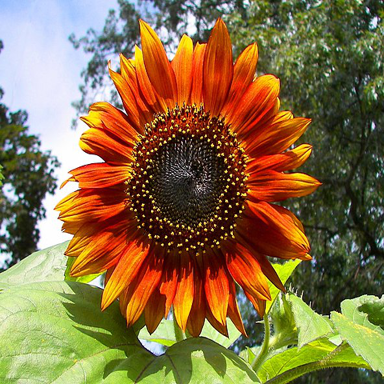

In [9]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)


img = Image.open(sunflower_path).resize((384, 384))
from io import BytesIO

buffered = BytesIO()
img.save(buffered, format="JPEG")

bytes_input = base64.b64encode(buffered.getvalue()).decode("utf-8")
instances = [{'b64': bytes_input}]
img

In [10]:
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
predictions = endpoint.predict(instances=instances)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 98.76 percent confidence.


2022-11-18 08:46:47.503312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 08:46:47.586695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 08:46:47.588566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 08:46:47.591720: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

#### Batch predictions

In [36]:
import base64
import json
from io import BytesIO

gcs_input_uri = f"gs://{BUCKET_NAME}/test2.jsonl"
with tf.io.gfile.GFile(gcs_input_uri, "w") as f:
    sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
    sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
    img = Image.open(sunflower_path).resize((384, 384))
    buffered = BytesIO()
    img.save(buffered, format="JPEG")
    bytes_input = base64.b64encode(buffered.getvalue()).decode("utf-8")
    data = {"b64": bytes_input}
    f.write(json.dumps(data) + "\n")
    # bytes = tf.io.read_file(test_item_2)
    # b64str = base64.b64encode(bytes.numpy()).decode("utf-8")
    # data = {serving_input: {"b64": b64str}}
    # f.write(json.dumps(data) + "\n")

In [30]:
DEPLOYED_NAME

'vision_prediction_frmlz-7l3oe'

In [32]:
model

resource name: projects/446303513828/locations/europe-west4/models/7686175616386727936

In [37]:
MIN_NODES = 1
MAX_NODES = 1

batch_predict_job = model.batch_predict(
    job_display_name=f"{DEPLOYED_NAME}_batch_2",
    gcs_source=gcs_input_uri,
    gcs_destination_prefix=f"gs://{BUCKET_NAME}",
    instances_format="jsonl",
    model_parameters=None,
    machine_type=DEPLOY_COMPUTE,
    starting_replica_count=MIN_NODES,
    max_replica_count=MAX_NODES,
    generate_explanation=False,
    sync=False,
)

print(batch_predict_job)

Creating BatchPredictionJob
<google.cloud.aiplatform.jobs.BatchPredictionJob object at 0x7f2e6d0c1510> is waiting for upstream dependencies to complete.
BatchPredictionJob created. Resource name: projects/446303513828/locations/europe-west4/batchPredictionJobs/2295581267191660544
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/446303513828/locations/europe-west4/batchPredictionJobs/2295581267191660544')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/europe-west4/batch-predictions/2295581267191660544?project=446303513828
BatchPredictionJob projects/446303513828/locations/europe-west4/batchPredictionJobs/2295581267191660544 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/446303513828/locations/europe-west4/batchPredictionJobs/2295581267191660544 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/446303513828/locations/europe-west4/batchPredictionJobs/22955812671916

In [56]:
import pandas as pd

batch_predict_job.to_dict()['outputInfo']['gcsOutputDirectory']
tf.nn.softmax([0.967276752, -1.96995211, -2.18606353, 4.22435474, -1.44914544])

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.0368209 , 0.00195197, 0.00157259, 0.95636857, 0.00328591],
      dtype=float32)>

## (DO NOT RUN) Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:



In [5]:
endpoints = vertex_ai.Endpoint.list()

In [6]:
endpoints

 resource name: projects/446303513828/locations/europe-west4/endpoints/384925826744844288,
 resource name: projects/446303513828/locations/europe-west4/endpoints/8743606735144484864]

In [7]:
for endpoint in endpoints:
    models = endpoint.list_models()
    for model in models:
        endpoint.undeploy(model.id)
        print(f'undeployed {model.id}')
    vertex_ai.Endpoint.delete(endpoint)

Undeploying Endpoint model: projects/446303513828/locations/europe-west4/endpoints/384925826744844288
Undeploy Endpoint model backing LRO: projects/446303513828/locations/europe-west4/endpoints/384925826744844288/operations/6654678128637509632
Endpoint model undeployed. Resource name: projects/446303513828/locations/europe-west4/endpoints/384925826744844288
undeployed 8967396933815500800
Deleting Endpoint : projects/446303513828/locations/europe-west4/endpoints/384925826744844288
Delete Endpoint  backing LRO: projects/446303513828/locations/europe-west4/operations/6771771718949142528
Endpoint deleted. . Resource name: projects/446303513828/locations/europe-west4/endpoints/384925826744844288
Undeploying Endpoint model: projects/446303513828/locations/europe-west4/endpoints/8743606735144484864
Undeploy Endpoint model backing LRO: projects/446303513828/locations/europe-west4/endpoints/8743606735144484864/operations/8113844407905550336
Endpoint model undeployed. Resource name: projects/446

In [8]:
models = vertex_ai.Model.list()
models

 resource name: projects/446303513828/locations/europe-west4/models/884614279150436352,
 resource name: projects/446303513828/locations/europe-west4/models/7686175616386727936]

In [9]:
for model in models:
    vertex_ai.Model.delete(model)

Deleting Model : projects/446303513828/locations/europe-west4/models/884614279150436352
Delete Model  backing LRO: projects/446303513828/locations/europe-west4/operations/619854627961044992
Model deleted. . Resource name: projects/446303513828/locations/europe-west4/models/884614279150436352
Deleting Model : projects/446303513828/locations/europe-west4/models/7686175616386727936
Delete Model  backing LRO: projects/446303513828/locations/europe-west4/operations/8441481280796753920
Model deleted. . Resource name: projects/446303513828/locations/europe-west4/models/7686175616386727936


In [10]:
pipelines = vertex_ai.PipelineJob.list()

In [11]:
pipelines

[]

In [12]:
jobs = vertex_ai.CustomTrainingJob.list()

In [13]:
for job in jobs:
    vertex_ai.CustomTrainingJob.delete(job)

Deleting CustomTrainingJob : projects/446303513828/locations/europe-west4/trainingPipelines/5182951578289569792
Delete CustomTrainingJob  backing LRO: projects/446303513828/locations/europe-west4/operations/4465928709735448576
CustomTrainingJob deleted. . Resource name: projects/446303513828/locations/europe-west4/trainingPipelines/5182951578289569792


In [14]:
jobs = vertex_ai.CustomJob.list()

In [15]:
for job in jobs:
    vertex_ai.CustomTrainingJob.delete(job)

Deleting CustomJob : projects/446303513828/locations/europe-west4/customJobs/1469592948034240512
Delete CustomJob  backing LRO: projects/446303513828/locations/europe-west4/operations/2259164892323905536
CustomJob deleted. . Resource name: projects/446303513828/locations/europe-west4/customJobs/1469592948034240512
